In [57]:
# %cd ..
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %load_ext autotime

import os
import pandas as pd
import numpy as np
import catboost as ctb
from sklearn import metrics


2019-08-27 19:21:59,766 DEBUG    Loaded backend module://ipykernel.pylab.backend_inline version unknown.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
prediction_example = pd.read_csv('prediction_example.csv')
promotion_schedule = pd.read_csv('promotion_schedule.csv')
train = pd.read_csv('train.csv')
train.tail()

,i,j,t,price,advertised
76497,1989,30,48,1.961365,0
76498,1990,15,48,0.924350,0
76499,1991,6,48,0.799155,0
76500,1994,30,48,1.961365,0
76501,1999,13,48,2.295451,0


In [59]:
promotion_schedule.advertised.value_counts()

0    38
1     1
Name: advertised, dtype: int64

In [61]:
promotion_schedule[promotion_schedule.advertised == 1]

,j,discount,advertised
23,24,0.2,1


In [62]:
bought_last_week = train[train.t == 0].i.value_counts()


In [63]:
train.groupby('t').count().mean()

i             1561.265306
j             1561.265306
price         1561.265306
advertised    1561.265306
dtype: float64

In [64]:
t_len = 1561*10
for i in range(49):
    neg_sample_data = np.stack([np.random.randint(0, 2000, t_len), np.random.randint(0, 40, t_len),
                            np.full(t_len, i), np.zeros(t_len), np.zeros(t_len)]).T
    train = train.append(pd.DataFrame(neg_sample_data, 
                 columns=['i', 'j', 't', 'price', 'advertised']), ignore_index=True, sort=False)
    

train = train.drop_duplicates(['i', 'j', 't'], keep='first').sort_values(['t','i']).reset_index(drop=True)
train.tail()

,i,j,t,price,advertised
757782,1999.0,29.0,48.0,0.0,0.0
757783,1999.0,28.0,48.0,0.0,0.0
757784,1999.0,30.0,48.0,0.0,0.0
757785,1999.0,32.0,48.0,0.0,0.0
757786,1999.0,23.0,48.0,0.0,0.0


## Have to create normal validation set

In [50]:
val = train[train.t == train.t.max()]
empty_data = (np.stack([np.arange(0, 2000).repeat(40), np.tile(np.arange(0, 40), 2000), 
          np.full(80_000, 48), np.zeros(80_000),np.zeros(80_000)]).T)
empty_df = pd.DataFrame(empty_data, columns=val.columns)
val = val.append(empty_df, ignore_index=True, sort=False).drop_duplicates(['i', 'j', 't'], keep='first')
val = val.sort_values(['t','i']).reset_index(drop=True)
val.tail()

,i,j,t,price,advertised
79995,1999.0,33.0,48.0,0.0,0.0
79996,1999.0,35.0,48.0,0.0,0.0
79997,1999.0,36.0,48.0,0.0,0.0
79998,1999.0,38.0,48.0,0.0,0.0
79999,1999.0,39.0,48.0,0.0,0.0


### Let's try classic co-occurance matrix

In [23]:
train.price = (train.price > 0).astype(int)
cols2rename = {'i':'userID', 'j': 'itemID', 't': 'timestamp', 'price': 'rating'}
train = train.rename(columns=cols2rename)

from reco_utils.dataset.python_splitters import python_chrono_split

train, test = python_chrono_split(train, 0.85)

# set log level to INFO
import logging
logging.basicConfig(level=logging.DEBUG, 
                    format='%(asctime)s %(levelname)-8s %(message)s')

from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, auc
from reco_utils.recommender.sar.sar_singlenode import SARSingleNode

model = SARSingleNode(
    timedecay_formula=True,
    time_now=49,
    time_decay_coefficient=7*20
)

model.fit(train)

TOP_K = 40
top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=False)
top_k.head()

2019-08-27 19:00:42,476 INFO     Collecting user affinity matrix
2019-08-27 19:00:42,493 INFO     Calculating time-decayed affinities
2019-08-27 19:00:42,659 INFO     Creating index columns
2019-08-27 19:00:42,709 INFO     Building user affinity sparse matrix
2019-08-27 19:00:42,715 INFO     Calculating item co-occurrence
2019-08-27 19:00:42,768 INFO     Calculating item similarity
2019-08-27 19:00:42,769 INFO     Using jaccard based similarity
2019-08-27 19:00:42,771 INFO     Done training
2019-08-27 19:00:42,789 INFO     Calculating recommendation scores


,userID,itemID,prediction
0,0.0,19.0,7.55192
1,0.0,37.0,7.55192
2,0.0,17.0,7.55192
3,0.0,28.0,7.55192
4,0.0,29.0,7.55192


In [24]:
top_k.prediction = top_k.prediction.map(lambda x: 1 if x >=1 else x)

# all ranking metrics have the same arguments
args = [test, top_k]
kwargs = dict(
              k=TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)
eval_auc = auc(*args)
eval_auc

0.5596115367140322

In [25]:
print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 40
MAP:		 1.416237
NDCG:		 1.414744
Precision@K:	 1.420450
Recall@K:	 1.000000


In [26]:
top_k = top_k.sort_values(['userID', 'itemID']).reset_index(drop=True)

In [29]:
metrics.roc_auc_score((val.price > 0).astype(int),top_k.prediction.tolist())

0.6052412242619416

we do not account time

### Let's try fastai recsys

In [32]:
from fastai.collab import * 

data = CollabDataBunch.from_df(train, user_name='userID', item_name='itemID', 
                              rating_name='rating', test=test)
learn = collab_learner(data, n_factors=50, y_range=(0.,5.))
learn.fit_one_cycle(6, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.084789,0.083411,00:42
1,0.087311,0.084313,00:45
2,0.081000,0.083108,00:51
3,0.074950,0.081077,00:49
4,0.078297,0.078870,00:44
5,0.074333,0.078310,00:45


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x1a23965240>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x1a23965240>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/eamag/anaconda3/envs/reco_pyspark/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
  File "/Users/eamag/anaconda3/envs/reco_pyspark/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/Users/eamag/anaconda3/envs/reco_pyspark/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  File "/Users/eamag/anaconda3/envs/reco_pyspark/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
  

In [33]:
np.unique(learn.get_preds(data)[1], return_counts=True)

(array([0., 1.], dtype=float32), array([462806,  52277]))

In [34]:
learn.model.eval()

tt_users = torch.tensor(np.arange(0, 2000).repeat(40))

tt_items = torch.tensor(np.tile(np.arange(0, 40), 2000))

res = learn.model(tt_users, tt_items)

np.unique(res > 1, return_counts=True)

(array([False,  True]), array([77961,  2039]))

In [41]:
metrics.roc_auc_score((val.price > 0).astype(int),(res > 1).numpy().astype(int))

0.8754022770870618

Good result, but no time features again

## Let's try good old boosting

In [51]:
train = train[train.t != 48] # rerun train val part before

cat_features_idxs = [0,1,3]

train.price = (train.price > 0).astype(int)
val.price = (val.price > 0).astype(int)


train_pool = ctb.Pool(train.drop(columns=['price']), train.price, cat_features_idxs)
validation_pool = ctb.Pool(val.drop(columns=['price']), val.price, cat_features_idxs)

params = {
    'loss_function': 'Logloss',
    'iterations': 300,
    'early_stopping_rounds':50,
    'custom_metric': ['Accuracy']
}
model = ctb.CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validation_pool, verbose=True, plot=False)

from sklearn import metrics
res = model.predict_proba(val.drop(columns=['price']))[:, 1]
metrics.roc_auc_score(val.price.tolist(),res)

Learning rate set to 0.261491
0:	learn: 0.4558840	test: 0.4141824	best: 0.4141824 (0)	total: 613ms	remaining: 3m 3s
1:	learn: 0.3508647	test: 0.2804147	best: 0.2804147 (1)	total: 1s	remaining: 2m 29s
2:	learn: 0.3089724	test: 0.2186200	best: 0.2186200 (2)	total: 1.47s	remaining: 2m 25s
3:	learn: 0.2864920	test: 0.1816406	best: 0.1816406 (3)	total: 1.88s	remaining: 2m 19s
4:	learn: 0.2777287	test: 0.1620782	best: 0.1620782 (4)	total: 2.23s	remaining: 2m 11s
5:	learn: 0.2703329	test: 0.1474935	best: 0.1474935 (5)	total: 2.63s	remaining: 2m 9s
6:	learn: 0.2640935	test: 0.1378938	best: 0.1378938 (6)	total: 3.16s	remaining: 2m 12s
7:	learn: 0.2604279	test: 0.1303326	best: 0.1303326 (7)	total: 3.54s	remaining: 2m 9s
8:	learn: 0.2584870	test: 0.1265704	best: 0.1265704 (8)	total: 3.91s	remaining: 2m 6s
9:	learn: 0.2570864	test: 0.1235407	best: 0.1235407 (9)	total: 4.54s	remaining: 2m 11s
10:	learn: 0.2561714	test: 0.1224347	best: 0.1224347 (10)	total: 5.18s	remaining: 2m 15s
11:	learn: 0.25550

0.8380077818828879

* 0.8425417406784845 with augmented *1
* 0.8383376183560397 with augmented *10, 0.7566958420976801 if threshold is 0.1

In [52]:
np.unique((res > 0.5).astype(int), return_counts=True)

(array([0, 1]), array([78669,  1331]))

In [53]:
np.unique(val.price, return_counts=True)

(array([0, 1]), array([78467,  1533]))

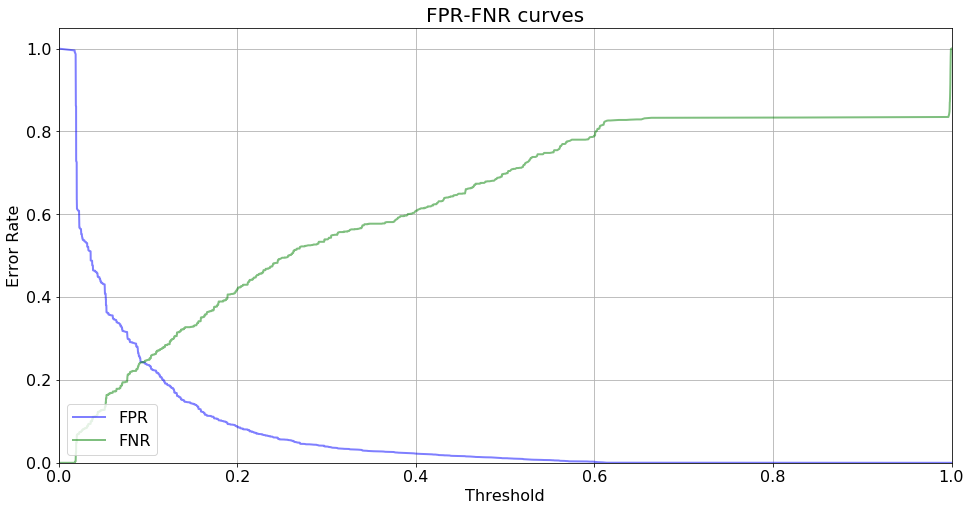

In [56]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [55]:
metrics.roc_auc_score(val.price.tolist(),(res > 0.1).astype(int))

0.7575695313300215

We need 25 iterations

## Create out file

In [65]:
cat_features_idxs = [0,1,3]# rerun train val part before
train.price = (train.price > 0).astype(int)
train_pool = ctb.Pool(train.drop(columns=['price']), train.price, cat_features_idxs)
params = {
    'loss_function': 'Logloss',
    'iterations': 26,
    'custom_metric': ['Accuracy']
}
model = ctb.CatBoostClassifier(**params)
model.fit(train_pool, verbose=True, plot=False)

Learning rate set to 0.5
0:	learn: 0.4279932	total: 203ms	remaining: 5.08s
1:	learn: 0.3352462	total: 385ms	remaining: 4.61s
2:	learn: 0.2947935	total: 551ms	remaining: 4.22s
3:	learn: 0.2764159	total: 755ms	remaining: 4.15s
4:	learn: 0.2681500	total: 952ms	remaining: 4s
5:	learn: 0.2647790	total: 1.19s	remaining: 3.96s
6:	learn: 0.2635182	total: 1.36s	remaining: 3.68s
7:	learn: 0.2629127	total: 1.52s	remaining: 3.42s
8:	learn: 0.2628209	total: 1.64s	remaining: 3.1s
9:	learn: 0.2625430	total: 1.84s	remaining: 2.94s
10:	learn: 0.2624328	total: 2.39s	remaining: 3.26s
11:	learn: 0.2623561	total: 2.71s	remaining: 3.16s
12:	learn: 0.2623183	total: 2.92s	remaining: 2.92s
13:	learn: 0.2621506	total: 3.08s	remaining: 2.64s
14:	learn: 0.2621326	total: 3.33s	remaining: 2.44s
15:	learn: 0.2619496	total: 3.57s	remaining: 2.23s
16:	learn: 0.2619406	total: 3.73s	remaining: 1.97s
17:	learn: 0.2617986	total: 3.93s	remaining: 1.75s
18:	learn: 0.2616454	total: 4.11s	remaining: 1.51s
19:	learn: 0.2616295

In [86]:
val = val.sort_values(['i', 'j']).reset_index(drop=True)

val.t = 49

val.loc[val.j == 24, 'advertised'] = 1

val = val.drop(columns=['price'])
res = model.predict(val)
val['prediction'] = res

val[['i', 'j', 'prediction']].to_csv('prediction_roc_0.83.csv')